In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pixel_level_contrastive_learning import PixelCL
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
import matplotlib.pyplot as plt
from datetime import datetime
from video_dataset import VideoFrameDataset
from rrunet import RR_UNET
from simvp import SimVP

### Load Dataset

In [2]:
transform = transforms.Compose([
    transforms.Pad(padding=(0, 40), padding_mode='edge'),  # Only pad width
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5002, 0.4976, 0.4945], std=[0.0555, 0.0547, 0.0566])  # Standard normalization
])

root_dir = '/home/yibin/workspace/dl/final_completion/dataset_student/dataset' # Change this to the path of the dataset
train_set = VideoFrameDataset(root_dir, 'train', transform)
val_set = VideoFrameDataset(root_dir, 'val', transform)
unlabeled_set = VideoFrameDataset(root_dir, 'unlabeled', transform)
hidden_set = VideoFrameDataset(root_dir, 'hidden', transform)
batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
demo_test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(hidden_set, batch_size=batch_size, shuffle=False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
videos, first_frames, last_frame, masks, last_mask, _ = next(iter(demo_test_loader))
videos = videos.to(device)
first_frames = first_frames.to(device)
last_frame = last_frame.to(device)
masks = masks.to(device)
last_mask = last_mask.to(device)

In [9]:
videos.shape, first_frames.shape, last_frame.shape, masks.shape, last_mask.shape

(torch.Size([1, 22, 3, 240, 240]),
 torch.Size([1, 11, 3, 240, 240]),
 torch.Size([1, 3, 240, 240]),
 torch.Size([1, 22, 160, 240]),
 torch.Size([1, 160, 240]))

In [12]:
def imshow(tensor):
    # Assuming tensor is normalized in the typical range for pretrained models
    mean = torch.tensor([0.5002, 0.4976, 0.4945])
    std = torch.tensor([0.0555, 0.0547, 0.0566])

    # Denormalize the image
    tensor = tensor.clone()  # Clone the tensor so not to do changes on the original
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Multiply by std and then add the mean

    # Convert tensor to image
    image = tensor.permute(1, 2, 0)  # Change from CxHxW to HxWxC format
    image = image.numpy()  # Convert to numpy array

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # No axis to show
    plt.show()

### Load SimVP for Mask Generation

In [14]:
frame_pred_model = SimVP(shape_in=[11,1,160,240], out_channel=49)
frame_pred_model = torch.load('/home/yibin/workspace/dl/final_completion/finetune-simvp-mask-seq-frame_pre-model-04_29_2024_210630/checkpoint.pt') # path to your model
frame_pred_model.to(device)

SimVP(
  (enc): Encoder(
    (enc): Sequential(
      (0): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (1): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (2): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (

### Test on Validation Set

In [29]:
sample_outputs_list = []
truth_list = []
frame_pred_model.eval()
with torch.no_grad():
    for _, _, _, masks, last_mask, _ in demo_test_loader:
        first_eleven_masks = masks[:, :11].unsqueeze(2).to(device)
        pred = frame_pred_model(first_eleven_masks)
        pred = torch.argmax(pred, dim=1)
        pred = pred[-1].cpu().detach()
        sample_outputs_list.append(pred)
        truth_list.append(last_mask[0])

In [30]:
sample_all_outputs = torch.stack(sample_outputs_list, dim=0)
sample_all_truth = torch.stack(truth_list, dim=0)

In [31]:
sample_all_outputs.shape, sample_all_truth.shape

(torch.Size([1000, 160, 240]), torch.Size([1000, 160, 240]))

In [32]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(task="multiclass", num_classes=49)
jaccard(sample_all_outputs, sample_all_truth)

tensor(0.3337)

### Verify Predicted Output

In [53]:
num = 18

#### Ground Truth Mask

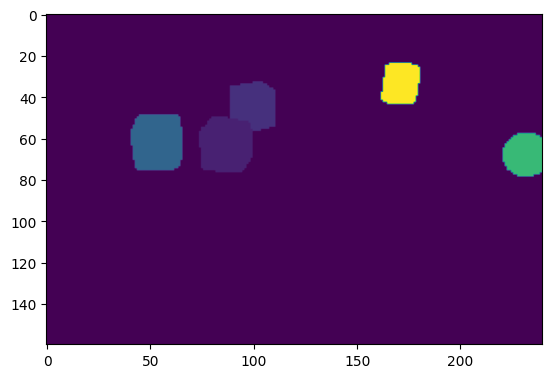

In [54]:
plt.imshow(sample_all_truth[num])

#### Predicted Mask

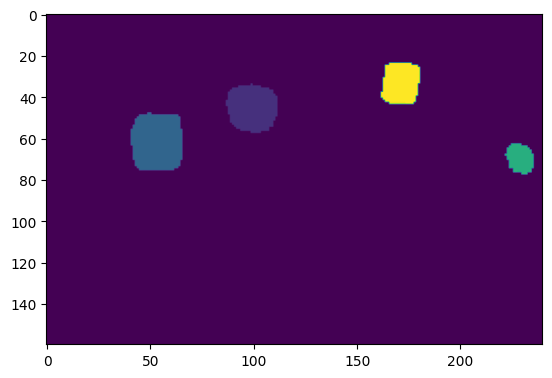

In [55]:
plt.imshow(sample_all_outputs[num])

### Generate Final Result

In [33]:
outputs_list = []
frame_pred_model.eval()
path_list = []
with torch.no_grad():
    for _, _, _, masks, last_mask, path in test_loader:
        first_eleven_masks = masks[:, :11].unsqueeze(2).to(device)
        pred = frame_pred_model(first_eleven_masks)
        pred = torch.argmax(pred, dim=1)
        pred = pred[-1].cpu()
        pred = pred.squeeze(0)
        outputs_list.append(pred)
        path_list.append(path)
all_outputs = torch.stack(outputs_list, dim=0)

In [34]:
all_outputs.shape

torch.Size([5000, 160, 240])

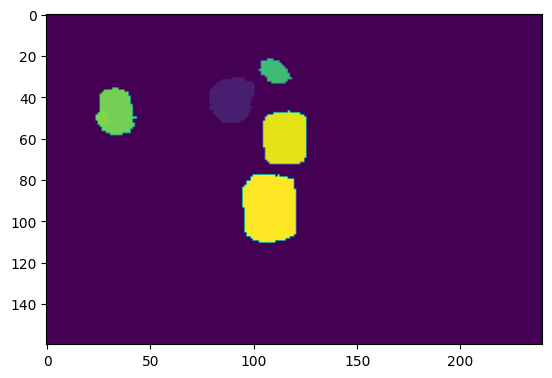

In [36]:
plt.imshow(all_outputs[num].cpu().numpy())

### Save Model

In [37]:
torch.save(all_outputs.to(torch.uint8), 'team_11.pt')